In [ ]:
from metrics import Distance
from matplotlib import pyplot as plt
from mlflux.eval import heatmap, annotate_heatmap
from metrics import Stoch
import numpy as np
import xarray as xr
%load_ext autoreload
%autoreload 3

### Check flux read in

In [8]:

dir = '/scratch/jw8736/gotm/ensem_old/2011-01-01_2020-01-01_heat/'
years = (2011,2012,2013,2015,2016)

from mlflux.gotm import read_vars
Q_bulk = {'filename':'heatflux_bulk.dat', 'columns':['Q']}
files = [Q_bulk]
df = read_vars (path=dir, files=files, datetimeformat='%Y-%m-%d %H:%M:%S')
ds_Q = df.set_index('datetime').to_xarray()

tau = {'filename':'momentumflux.dat', 'columns':['taux', 'tauy']}
files = [tau]
df = read_vars (path=dir, files=files, datetimeformat='%Y-%m-%d %H:%M:%S')
ds_tau = df.set_index('datetime').to_xarray()

swr = {'filename':'swr.dat', 'columns':['swr']}
files = [swr]
df = read_vars (path=dir, files=files, datetimeformat='%Y-%m-%d %H:%M:%S')
ds_swr = df.set_index('datetime').to_xarray()

# ds_list = []
# for i in range(1,21):
#     files = [{'filename':f'heatflux_ann_ensem{i}.dat', 'columns':['Q']} ]
#     df = read_vars (path=dir, files=files, datetimeformat='%Y-%m-%d %H:%M:%S')
#     ds_ = df.set_index('datetime').to_xarray()
#     ds_list.append(ds_)
    
# ds_ensem = xr.concat(ds_list, dim='ensem')
# ds['Q_ensem_mean'] = ds_ensem.Q.mean(dim='ensem').copy()

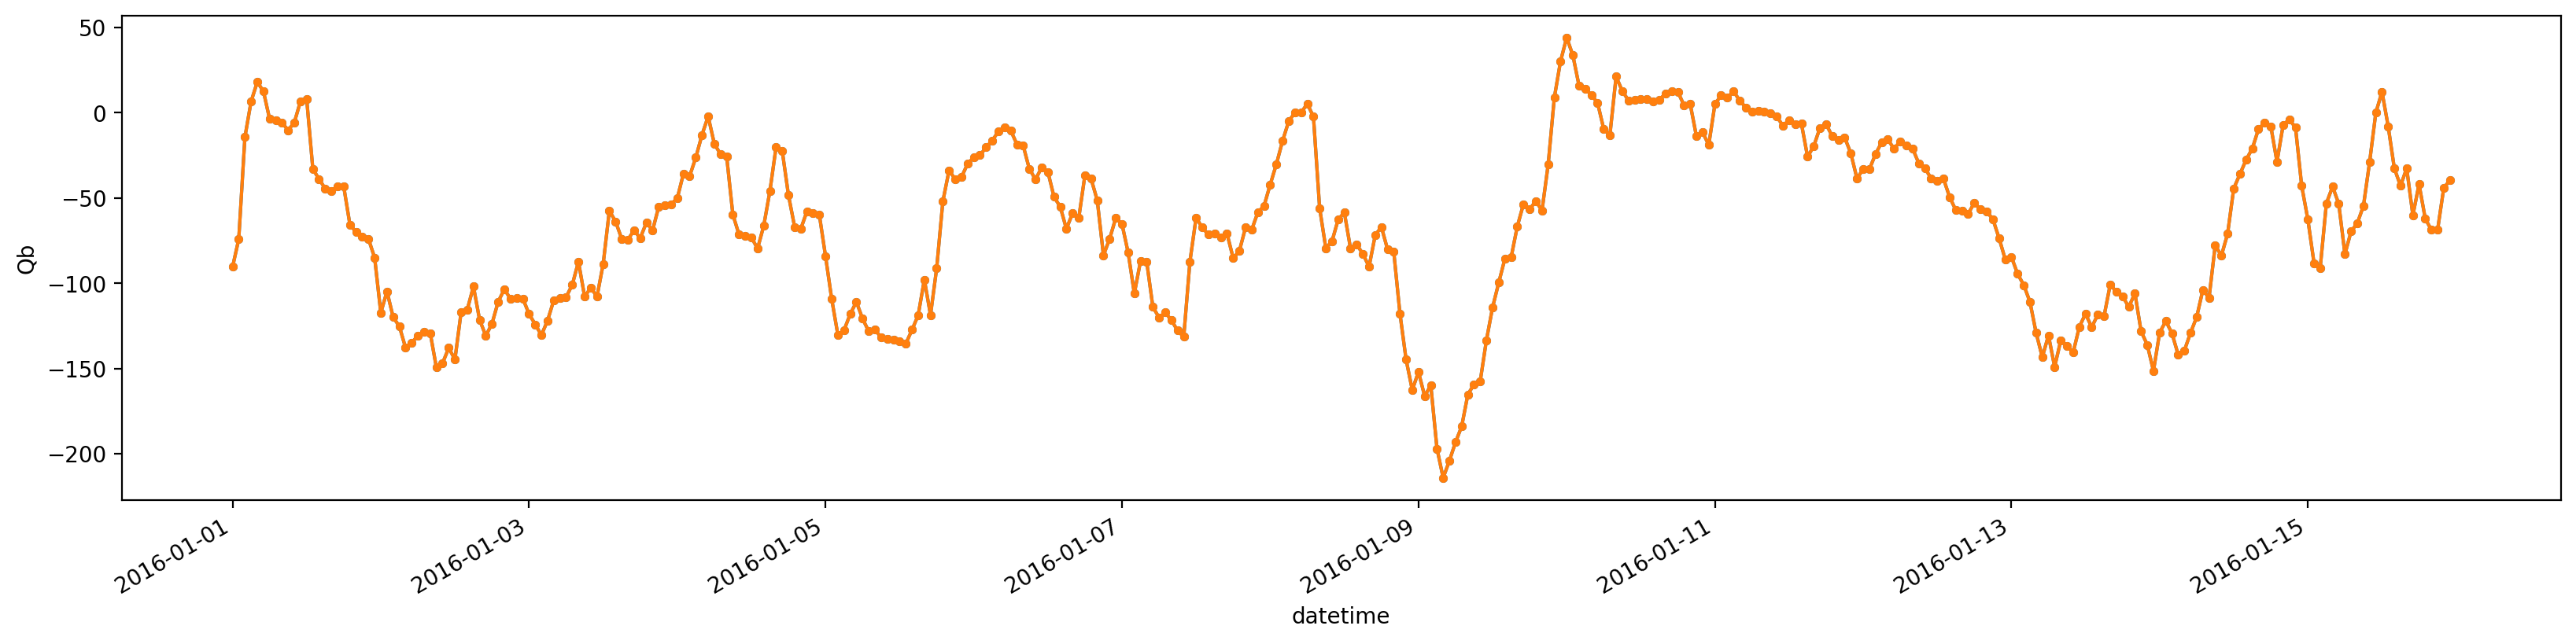

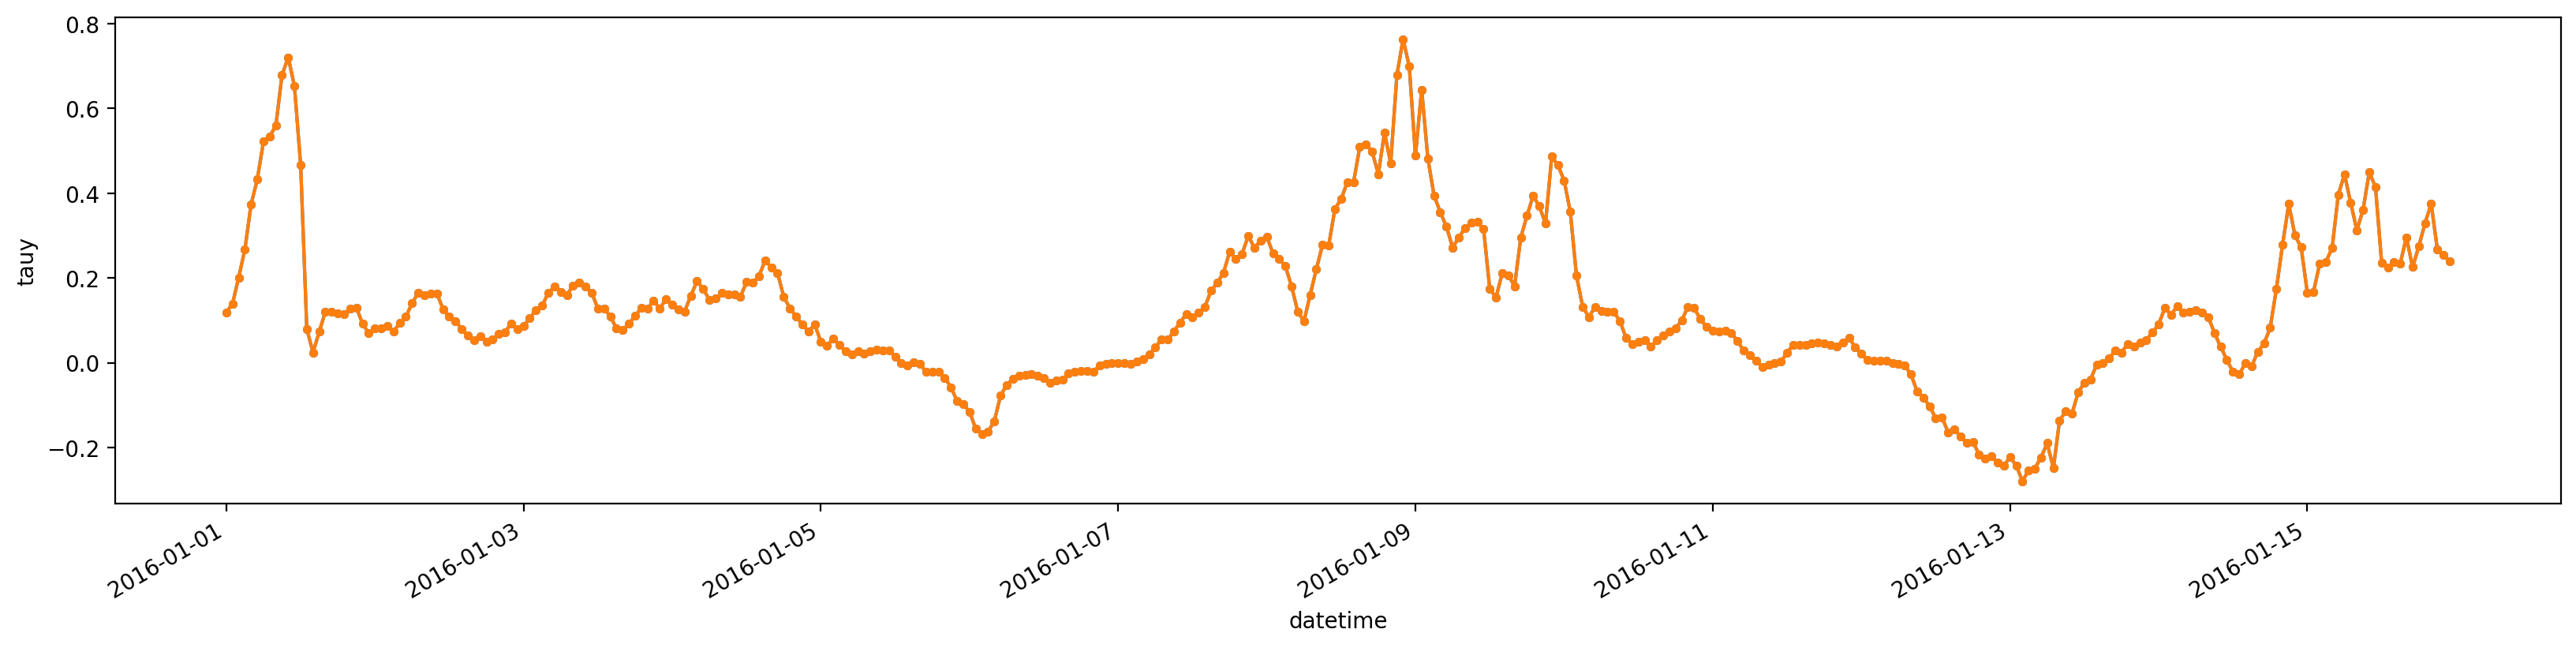

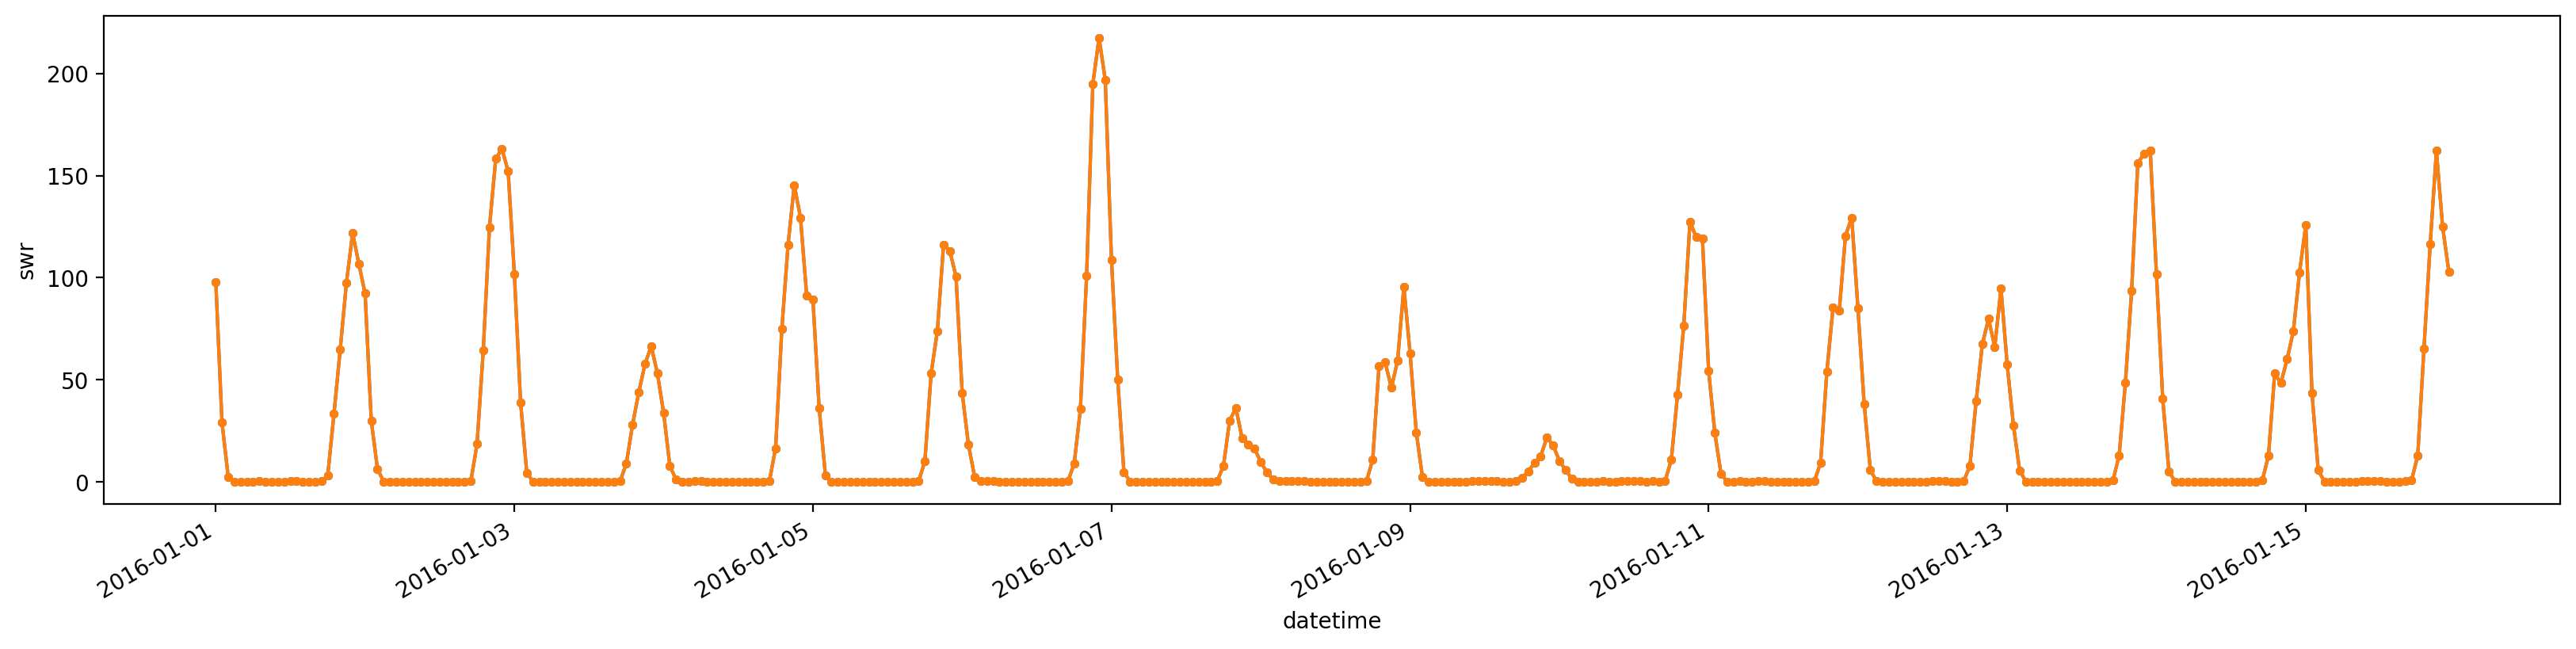

In [ ]:
# Visualizing the hourly flux read in and checking that it agrees with the flux file
# They should agree
import xarray as xr
fig = plt.figure(figsize=[20,4], dpi=200)
ds_run = xr.open_dataset('/scratch/jw8736/gotm/ensem_old/2011-01-01_2020-01-01_heat/'+'out_kpp_dt60_2016/' + 'out_bulk.nc')
ds_run.Q.sel(t=slice('2016-01-01','2016-01-15')).plot(marker='.')
ds.Qb.sel(datetime=slice('2016-01-01','2016-01-15')).plot(marker='.')

fig = plt.figure(figsize=[20,4], dpi=200)
ds_run = xr.open_dataset('/scratch/jw8736/gotm/ensem_old/2011-01-01_2020-01-01_heat/'+'out_kpp_dt60_2016/' + 'out_bulk.nc')
ds_run.tauy.sel(t=slice('2016-01-01','2016-01-15')).plot(marker='.')
ds_tau.tauy.sel(datetime=slice('2016-01-01','2016-01-15')).plot(marker='.')

fig = plt.figure(figsize=[20,4], dpi=200)
ds_run = xr.open_dataset('/scratch/jw8736/gotm/ensem_old/2011-01-01_2020-01-01_heat/'+'out_kpp_dt60_2016/' + 'out_bulk.nc')
ds_run.swr.isel(z=0).sel(t=slice('2016-01-01','2016-01-15')).plot(marker='.')
ds_swr.swr.sel(datetime=slice('2016-01-01','2016-01-15')).plot(marker='.')

### Check the years used

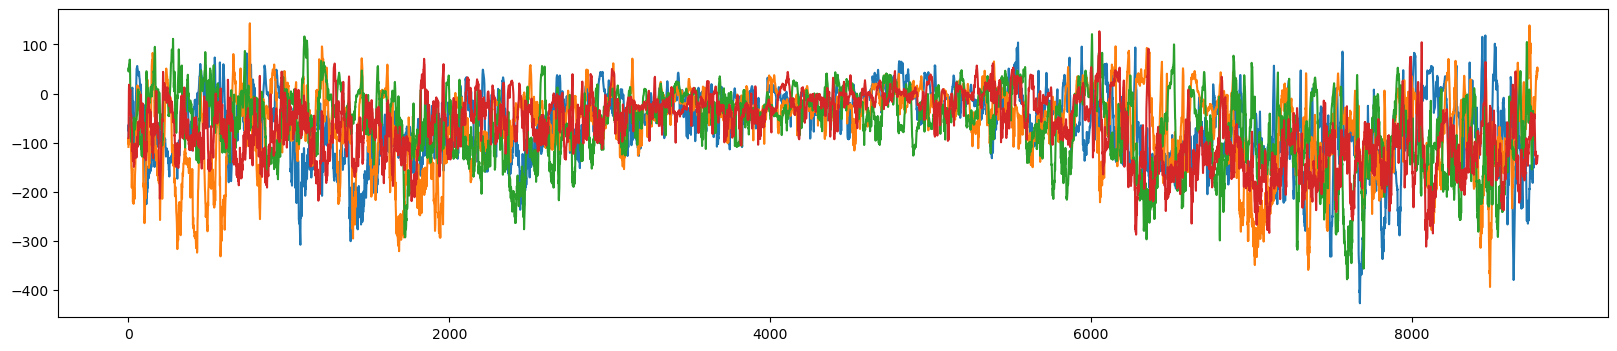

In [10]:
fig = plt.figure(figsize=[20,4])
# 2013 has a big flat part
for year in (2011,2012,2015,2016):
    ds_run = xr.open_dataset('/scratch/jw8736/gotm/ensem_old/2011-01-01_2020-01-01_heat/'+f'out_kpp_dt60_{year}/' + 'out_bulk.nc')
    plt.plot(ds_run.Q.values)

### Check different ways to compute fluxes
In `ensem` the height of ship was assumed (which is wrong but consistent)

In `ensem_old` the bulk flux of ows_papa files was used (the older version)

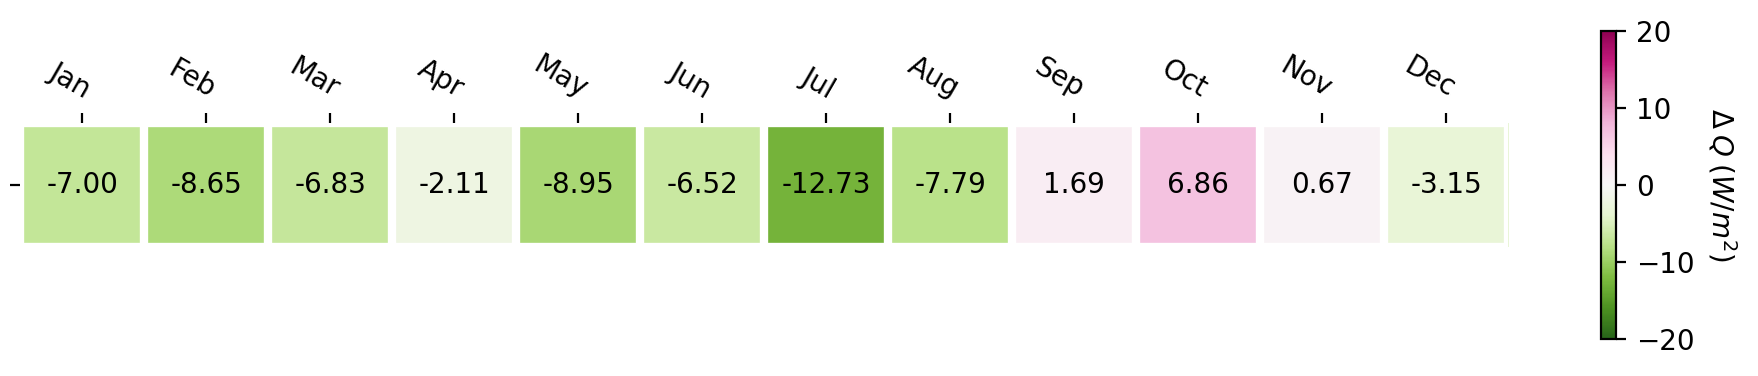

In [16]:
from mlflux.gotm import read_vars
fig = plt.figure(figsize=[12,2], dpi=200); ax = plt.gca()

dir = '/scratch/jw8736/gotm/ensem_old/2011-01-01_2020-01-01_heat/'
years = (2011,2012,2015,2016)

file_ann = {'filename':'heatflux_ann_mean.dat', 'columns':['Q']} 
file_bulk = {'filename':'heatflux_bulk.dat', 'columns':['Qb']}

files = [file_ann, file_bulk]
df = read_vars (path=dir, files=files, datetimeformat='%Y-%m-%d %H:%M:%S')
ds = df.set_index('datetime').to_xarray()

Q_diffs = []
for year in years:
    ds_ = ds.where(ds.datetime.dt.year == year, drop=True)
    Q_diff = ds_.Q.resample(datetime='1M').mean() - ds_.Qb.resample(datetime='1M').mean()  
    Q_diffs.append(Q_diff)
Q_diff = np.array(Q_diff)

col_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
yaver_bias = np.average(Q_diffs, axis=0)
yaver_bias = np.array(yaver_bias).reshape(1,-1) 
im, cbar = heatmap(yaver_bias, row_labels=[], col_labels=col_labels, ax=ax, vmax=20, vmin=-20, cmap='PiYG_r', 
                   cbar_kw=None, cbarlabel=r"$\Delta \: Q \; (W/m^2)$")
texts = annotate_heatmap(im, data=yaver_bias, valfmt="{x:.2f}", textcolors=("white", "black"), threshold=-20)